In [63]:
""" Combine Annotation JSON files """

# only need to run once for ZJM dataset

import json
import glob

count = 0
def combine_annot_files(paths, skip_n_frames=20):
  frame_dict = dict()
  count = 1
  for path in paths:
    key_joints = []
    frames_n = 0
    for files in glob.glob(path):
      if frames_n % skip_n_frames == 0:
        with open(files, "r") as f:
          data = json.loads(f.read())
          key_joint = data["annots"][0]["keypoints"]
          key_joints.append(key_joint)
      frames_n += 1
    name = f"cam_{count}"
    frame_dict[name] = key_joints
    count += 1
  with open("./363/annots.json", "w") as write_file:
    json.dump(frame_dict, write_file)

paths = ["./363/annots/01/*.json",
         "./363/annots/06/*.json",
         "./363/annots/12/*.json",
         "./363/annots/18/*.json"]
combine_annot_files(paths)

with open("./363/annots.json", "r") as a_file:
  data = json.loads(a_file.read())

print(data["cam_1"])

In [1]:
print("kernel")

kernel


In [2]:
import cv2
import mediapipe as mp
import numpy as np
mp_pose = mp.solutions.pose

In [3]:
# https://colab.research.google.com/drive/1uCuA6We9T5r0WljspEHWPHXCT_2bMKUy#scrollTo=BAivyQ_xOtFp

cap = cv2.VideoCapture('video.mp4')
if (cap.isOpened()== False):
    print("Error opening video file")
  
ret, frame = cap.read()
with mp_pose.Pose(min_detection_confidence=0.7) as pose:
    while(ret):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        results = pose.process(frame)
        print(results.pose_landmarks)
        break
        ret, frame = cap.read()

    cap.release()
    cv2.destroyAllWindows()

landmark {
  x: 0.4449214041233063
  y: 0.23585599660873413
  z: 0.022258996963500977
  visibility: 0.9996215105056763
}
landmark {
  x: 0.4409843385219574
  y: 0.22609741985797882
  z: -0.0005943913129158318
  visibility: 0.999663233757019
}
landmark {
  x: 0.43883562088012695
  y: 0.22604069113731384
  z: -0.0005930059705860913
  visibility: 0.9996107220649719
}
landmark {
  x: 0.4364979863166809
  y: 0.22600847482681274
  z: -0.0005576988332904875
  visibility: 0.9995976090431213
}
landmark {
  x: 0.4469476640224457
  y: 0.22760294377803802
  z: -0.009062692523002625
  visibility: 0.9996292591094971
}
landmark {
  x: 0.4489794671535492
  y: 0.22860099375247955
  z: -0.009035974740982056
  visibility: 0.999596893787384
}
landmark {
  x: 0.4511817991733551
  y: 0.22981804609298706
  z: -0.009045209735631943
  visibility: 0.999489426612854
}
landmark {
  x: 0.43146687746047974
  y: 0.23528313636779785
  z: -0.06394602358341217
  visibility: 0.9995781779289246
}
landmark {
  x: 0.454320

In [6]:
cou
for i in mp_pose.PoseLandmark:
    print(i)

PoseLandmark.NOSE
PoseLandmark.LEFT_EYE_INNER
PoseLandmark.LEFT_EYE
PoseLandmark.LEFT_EYE_OUTER
PoseLandmark.RIGHT_EYE_INNER
PoseLandmark.RIGHT_EYE
PoseLandmark.RIGHT_EYE_OUTER
PoseLandmark.LEFT_EAR
PoseLandmark.RIGHT_EAR
PoseLandmark.MOUTH_LEFT
PoseLandmark.MOUTH_RIGHT
PoseLandmark.LEFT_SHOULDER
PoseLandmark.RIGHT_SHOULDER
PoseLandmark.LEFT_ELBOW
PoseLandmark.RIGHT_ELBOW
PoseLandmark.LEFT_WRIST
PoseLandmark.RIGHT_WRIST
PoseLandmark.LEFT_PINKY
PoseLandmark.RIGHT_PINKY
PoseLandmark.LEFT_INDEX
PoseLandmark.RIGHT_INDEX
PoseLandmark.LEFT_THUMB
PoseLandmark.RIGHT_THUMB
PoseLandmark.LEFT_HIP
PoseLandmark.RIGHT_HIP
PoseLandmark.LEFT_KNEE
PoseLandmark.RIGHT_KNEE
PoseLandmark.LEFT_ANKLE
PoseLandmark.RIGHT_ANKLE
PoseLandmark.LEFT_HEEL
PoseLandmark.RIGHT_HEEL
PoseLandmark.LEFT_FOOT_INDEX
PoseLandmark.RIGHT_FOOT_INDEX


In [1]:
""" Read Video File """

# not needed for the ZJM dataset
print("Connect to kernel")

Connect to kernel


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# from torchvision import transforms, datasets

from utils.ReadFile import ReadFile
from utils.util import generate_rays, get_closest_point, project_3d_to_2d, get_gt_annots, calculate_loss

# Check if you are using a specific weight initialization technique
from model import RayPoseAttention


In [3]:
import sys

epoch = 20
batch_size = 5
frame_sequence = 5
n_cams = 4
permutation_of_n_cams = sum([n for n in range(n_cams)])

if frame_sequence % 2 == 0:
  raise RuntimeError("frame_sequence must be an odd number.")

span = frame_sequence // 2

folder_paths = [
  "./363", "./364", "./365", "./366", "./367", "./368", "./369", "./370",
  "./371", "./377", "./378", "./379", "./380", "./381", "./382", "./383",
  "./384", "./385", "./386", "./387", "./388"
]

cam_sets = [
  [ 
    ["Rot_01", "T_01", "K_01"], ["Rot_06", "T_06", "K_06"],
    ["Rot_12", "T_12", "K_12"], ["Rot_18", "T_18", "K_18"]
  ],
  [ 
    ["Rot_03", "T_03", "K_03"], ["Rot_09", "T_09", "K_09"],
    ["Rot_15", "T_15", "K_15"], ["Rot_21", "T_21", "K_21"]
  ],
  [ 
    ["Rot_05", "T_05", "K_05"], ["Rot_11", "T_11", "K_11"],
    ["Rot_17", "T_17", "K_17"], ["Rot_23", "T_23", "K_23"]
  ]
]

model = RayPoseAttention(encoding_dim=[32, 128, 512], decoding_dim=[permutation_of_n_cams, permutation_of_n_cams, 1], n_sequence=frame_sequence, n_joints=25)
model.train()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for i in range(epoch):
  for folder_path in folder_paths:
    avg_loss_per_cam_set = 0.
    for cam_set in cam_sets:
      read_files = ReadFile(camera_folder_path=folder_path, annot_folder_path=folder_path)
      cams_params = read_files.get_camera_params(dataset="ZJM", 
                                                extri_file="extri.yml",
                                                intri_file="intri.yml",
                                                cam_list=cam_set)

      annots = read_files.get_annots(file_name="annots.json")
      rays = generate_rays(cams_params, annots)
      points = get_closest_point(rays, len(cam_set))    # shape => (n_frames, n_joints, nC2 combination, 3)      
      
      pts_torch = torch.from_numpy(points)
      for idx in range(0, pts_torch.size(0), span + batch_size):
        
        optimizer.zero_grad()
        
        inputs = pts_torch[idx : idx + span * 2 + batch_size]
        if inputs.size(0) == span * 2 + batch_size:
          output = model(inputs, batch_size)   # shape => (batch, n_joints, 3)
          
          pred_2d_multi_cam = project_3d_to_2d(output, cams_params)
          gt = get_gt_annots(annots, start=idx + span, end=idx + span + batch_size)
          loss = calculate_loss(pred_2d_multi_cam, gt, loss_func=criterion)

          avg_loss_per_cam_set += loss
          
          loss.backward(retain_graph=True)
          optimizer.step()
    print("average loss over the entire camera sets: ", avg_loss_per_cam_set/len(cam_sets))


torch.Size([9, 25, 6, 3])
torch.Size([9, 25, 6, 3])
torch.Size([9, 25, 6, 3])
torch.Size([9, 25, 6, 3])
torch.Size([9, 25, 6, 3])
torch.Size([9, 25, 6, 3])
torch.Size([9, 25, 6, 3])
torch.Size([9, 25, 6, 3])
torch.Size([9, 25, 6, 3])
torch.Size([9, 25, 6, 3])
torch.Size([9, 25, 6, 3])
torch.Size([9, 25, 6, 3])
torch.Size([9, 25, 6, 3])
torch.Size([9, 25, 6, 3])
torch.Size([9, 25, 6, 3])
torch.Size([9, 25, 6, 3])
torch.Size([9, 25, 6, 3])
torch.Size([9, 25, 6, 3])


IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection ="3d")

x = points[3:, 0]
y = points[3:, 1]
z = points[3:, 2]
ax.scatter3D(x, y, z)

x = points[0:3, 0]
y = points[0:3, 1]
z = points[0:3, 2]
ax.scatter3D(x, y, z, color = "green")

plt.show()

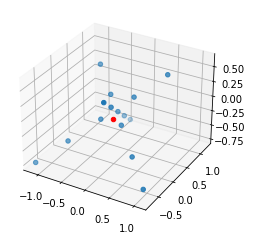

In [46]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection ="3d")

x = selected_points[:,0]
y = selected_points[:,1]
z = selected_points[:,2]
ax.scatter3D(x, y, z)

x = centroid[0][0]
y = centroid[0][1]
z = centroid[0][2]
ax.scatter3D(x, y, z, color = "red")

plt.show()